# Preprocessing and graph modeling

## Import

In [1]:
import pandas as pd
import re
import json
import numpy as np
from ordered_set import OrderedSet

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

from tqdm.auto import tqdm

import torch
from torch_geometric.data import HeteroData

from sklearn.feature_extraction.text import TfidfVectorizer

import pickle

c:\Users\Ilgar\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

In [2]:
def read_first_n_lines(file_path, n=10000):
    data = []
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i >= n:
                break
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(data)

file_path = 'data/arxiv-metadata-oai-snapshot.json'

df = read_first_n_lines(file_path, 10)

In [3]:
df.dtypes

id                object
submitter         object
authors           object
title             object
comments          object
journal-ref       object
doi               object
report-no         object
categories        object
license           object
abstract          object
versions          object
update_date       object
authors_parsed    object
dtype: object

In [4]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


## Preprocessing

### Transform columns

In [5]:
# extract number of pages from string: e.g. "37 pages, 15 figures; published version"

def extract_pages(s):
    match = re.search(r"(\d+)\s*pages", s)
    if match:
        return int(match.group(1))
    else:
        return None

In [6]:
# format columns to right format and extract information

df['authors_parsed'] = df['authors_parsed'].apply(lambda x: [" ".join(i).strip() for i in (eval(x) if isinstance(x, str) else x)]) # authors to name, first name and list
df['versions'] = df['versions'].apply(lambda x: eval(x)[0]["created"] if isinstance(x, str) else x) # first version / created
df['timestamp'] = df['versions'].apply(lambda x: x[0]['created'] if isinstance(x, list) and len(x) > 0 else None) # extract timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%a, %d %b %Y %H:%M:%S %Z", errors='coerce') # convert to datetime
df["categories"] = df["categories"].apply(lambda x: x.split(" ")) # seperate categories
df.drop(columns=["submitter", "versions", "update_date", "authors"], inplace=True) # drop unused columns
df["pages"] = df.comments.apply(lambda x: extract_pages(str(x))) # extract page number
df.head()

,id,title,comments,journal-ref,doi,report-no,categories,license,abstract,authors_parsed,timestamp,pages
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,[hep-ph],None,A fully differential calculation in perturba...,"[Balázs C., Berger E. L., Nadolsky P. M., Yuan...",2007-04-02 19:18:42+00:00,37.0
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,"[math.CO, cs.CG]",http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[Streinu Ileana, Theran Louis]",2007-03-31 02:26:18+00:00,NaN
2,0704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,[physics.gen-ph],None,The evolution of Earth-Moon system is descri...,[Pan Hongjun],2007-04-01 20:46:54+00:00,23.0
3,0704.0004,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,[math.CO],None,We show that a determinant of Stirling cycle...,[Callan David],2007-03-31 03:16:14+00:00,11.0
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,"[math.CA, math.FA]",None,In this paper we show how to compute the $\L...,"[Abu-Shammala Wael, Torchinsky Alberto]",2007-04-02 18:09:58+00:00,NaN


### Define size of dataset

In [7]:
# delete duplicates
df_short = df.drop_duplicates(subset='title', keep='first')
df_short = df_short.reset_index(drop=True)

### Lemmatization

In [8]:
nlp = spacy.load("en_core_web_sm")

def lemm(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

In [9]:
# use lemmatization to get the root of each word of the abstract and title
nlp = spacy.load("en_core_web_sm")
def lemma(docs=df.abstract):
    pip = nlp.pipe(docs, batch_size=32, n_process=-1, disable=["parser", "ner"])
    return [
        [tok.lemma_.lower() for tok in doc if not tok.is_punct and not tok.is_space]
        for doc in tqdm(pip, total=len(docs))
    ]


all_words = lemma(df_short["abstract"])
all_title_words = lemma(df_short["title"])

100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


In [10]:
# create lists that contain all entries of authors and categories

all_authors, all_categories= [], []

for index, row in df_short.iterrows():
    author = row['authors_parsed']
    category = row['categories'] 
    all_authors.append(author)
    all_categories.append(category)

print(all_authors)
print(all_categories)

[['Balázs C.', 'Berger E. L.', 'Nadolsky P. M.', 'Yuan C. -P.'], ['Streinu Ileana', 'Theran Louis'], ['Pan Hongjun'], ['Callan David'], ['Abu-Shammala Wael', 'Torchinsky Alberto'], ['Pong Y. H.', 'Law C. K.'], ['Corichi Alejandro', 'Vukasinac Tatjana', 'Zapata Jose A.'], ['Swift Damian C.'], ['Harvey Paul', 'Merin Bruno', 'Huard Tracy L.', 'Rebull Luisa M.', 'Chapman Nicholas', 'Evans Neal J. II', 'Myers Philip C.'], ['Ovchinnikov Sergei']]
[['hep-ph'], ['math.CO', 'cs.CG'], ['physics.gen-ph'], ['math.CO'], ['math.CA', 'math.FA'], ['cond-mat.mes-hall'], ['gr-qc'], ['cond-mat.mtrl-sci'], ['astro-ph'], ['math.CO']]


### Delete Stopwords

In [11]:
# delete stopwords in abstract and title
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

filtered_all_words = []
filtered_title_words = []

for words in all_words:
    filtered_words = [word for word in words if word not in stop_words]
    filtered_all_words.append(filtered_words)

for words in all_title_words:
    filtered_words = [word for word in words if word not in stop_words]
    filtered_title_words.append(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ilgar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### List with every word

In [12]:
# create lists with every value 

words_values = [word for sublist in filtered_all_words for word in sublist]

print(words_values)

authors_values = [author for sublist in all_authors for author in sublist]

categories_values = [category for sublist in all_categories for category in sublist]

title_values = [title for sublist in all_title_words for title in sublist]

['fully', 'differential', 'calculation', 'perturbative', 'quantum', 'chromodynamic', 'present', 'production', 'massive', 'photon', 'pair', 'hadron', 'collider', 'next', 'lead', 'order', 'perturbative', 'contribution', 'quark', 'antiquark', 'gluon-(anti)quark', 'gluon', 'gluon', 'subprocesse', 'include', 'well', 'order', 'resummation', 'initial', 'state', 'gluon', 'radiation', 'valid', 'next', 'next', 'lead', 'logarithmic', 'accuracy', 'region', 'phase', 'space', 'specify', 'calculation', 'reliable', 'good', 'agreement', 'demonstrate', 'datum', 'fermilab', 'tevatron', 'prediction', 'make', 'detailed', 'test', 'cdf', 'datum', 'prediction', 'show', 'distribution', 'diphoton', 'pair', 'produce', 'energy', 'large', 'hadron', 'collider', 'lhc', 'distribution', 'diphoton', 'pair', 'decay', 'higgs', 'boson', 'contrast', 'produce', 'qcd', 'process', 'lhc', 'show', 'enhance', 'sensitivity', 'signal', 'obtain', 'judicious', 'selection', 'event', 'describe', 'new', 'algorithm', '$', 'k,\\ell)$-peb

### Delete duplicates

In [13]:
# use orderedset to get unique values while preserving order
# https://www.geeksforgeeks.org/python-ordered-set/

categories_list = OrderedSet(categories_values)
authors_list = OrderedSet(authors_values)
title_words_list = OrderedSet(title_values)
words_list = OrderedSet(words_values)

# list with every word in abstract and title combined
all_words = words_list.union(title_words_list)
all_unique_words = OrderedSet(all_words)

In [14]:
len(all_unique_words)

514

### Create list with every attribute

In [15]:
licenses_list = df_short['license'].tolist()

doi_list = df_short['doi'].tolist()

title_list = df_short['title'].tolist()

comment_list = df_short['comments'].tolist()

journal_list = df_short['journal-ref'].tolist()
journal_list_set = OrderedSet(journal_list)

words_in_title_list = df_short['title'].tolist()

date_list = df_short['timestamp'].tolist()

id_list = df_short['id'].tolist()

pages_list = df_short['pages'].tolist()

## Create Hetero Object

In [16]:
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.HeteroData.html
# create the graph using heterodata from pytorch geometric

In [17]:
data = HeteroData()
data['paper'].num_nodes = len(df_short)
data['paper'].license = licenses_list
data['paper'].doi = doi_list
data['paper'].pages = pages_list
data['paper'].journal = journal_list
data['paper'].date = date_list
data['paper'].id = id_list

data['author'].num_nodes = len(authors_list)
data['category'].num_nodes = len(categories_list)
data['journal'].num_nodes = len(journal_list_set)
data['word'].num_nodes = len(all_unique_words)

data

HeteroData(
  paper={
    num_nodes=10,
    license=[10],
    doi=[10],
    pages=[10],
    journal=[10],
    date=[10],
    id=[10],
  },
  author={ num_nodes=24 },
  category={ num_nodes=10 },
  journal={ num_nodes=6 },
  word={ num_nodes=514 }
)

### Create edges

In [34]:
edge1

tensor([[ 0,  0,  0,  0,  1,  1,  2,  3,  4,  4,  5,  5,  6,  6,  6,  7,  8,  8,
          8,  8,  8,  8,  8,  9],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23]])

In [18]:
# create edges connecting the nodes

# edge paper written by author
unique_titles = df_short['title'].unique()

# create dicts to map title to id and id to title
title_to_id = {title:i for i, title in enumerate(unique_titles)}
id_to_paper = {i:title for i, title in enumerate(unique_titles)}

idtitle = df_short['title'].apply(lambda x: title_to_id[x])
# create dicts to map author to id and id to author
author_to_id = {author:i for i, author in enumerate(authors_list)}
id_to_author = {i:author for i, author in enumerate(authors_list)}

# create list of names and authors for each paper
data['paper'].title = [id_to_paper[i] for i in range(len(id_to_paper))]
data['author'].name = [id_to_author[i] for i in range(len(id_to_author))]

# list of lists with authors for each paper
authors_in_paper = [[author_to_id[author] for author in authors] for authors in all_authors]

# create edge by using two lists of same length, mapping the paper id to the author id
edge1 = [[paper_id, author_id] for paper_id, author_list in zip(idtitle, authors_in_paper) for author_id in author_list]
edge1 = torch.tensor(edge1).T

# add edge to graph
data['paper', 'written_by', 'author'].edge_index = edge1

# edge paper has category
category_to_id = {category:i for i, category in enumerate(categories_list)}
id_to_category = {i:category for i, category in enumerate(categories_list)}

data['category'].name = [id_to_category[i] for i in range(len(id_to_category))]

categories_in_paper = [[category_to_id[category] for category in categories] for categories in all_categories]

edge2 = [[paper_id, category_id] for paper_id, category_list in zip(idtitle, categories_in_paper) for category_id in category_list]
edge2 = torch.tensor(edge2).T

data['paper', 'has_category', 'category'].edge_index = edge2

# edge paper has word word


word_to_id = {word:i for i, word in enumerate(all_unique_words)}
id_to_word = {i:word for i, word in enumerate(all_unique_words)}

data['word'].name = [id_to_word[i] for i in range(len(id_to_word))]

words_in_paper = [[word_to_id[word] for word in words] for words in filtered_all_words]	

edge3 = [[paper_id, word_id] for paper_id, word_list in zip(idtitle, words_in_paper) for word_id in word_list]
edge3 = torch.tensor(edge3).T

data['paper', 'has_word', 'word'].edge_index = edge3

# edge paper has titleword word
words_in_title = [[word_to_id[word] for word in title] for title in filtered_title_words] 

edge4 = [[paper_id, word_id] for paper_id, word_list in zip(idtitle, words_in_title) for word_id in word_list]
edge4 = torch.tensor(edge4).T 

data['paper', 'has_titleword', 'word'].edge_index = edge4

# edge paper has journal journal

all_unique_journals = OrderedSet(journal_list)

journal_to_id = {journal:i for i, journal in enumerate(all_unique_journals)}
id_to_journal = {i:journal for i, journal in enumerate(all_unique_journals)}

data['journal'].name = [id_to_journal[i] for i in range(len(id_to_journal))]

journal_in_paper = [journal_to_id[journal] if journal in journal_to_id else None for journal in all_unique_journals]

edge5 = [[paper_id, journal_id] for paper_id, journal_id in zip(idtitle, journal_in_paper)]
edge5 = torch.tensor(edge5).T

data['paper', 'in_journal', 'journal-ref'].edge_index = edge5

In [19]:
data

HeteroData(
  paper={
    num_nodes=10,
    license=[10],
    doi=[10],
    pages=[10],
    journal=[10],
    date=[10],
    id=[10],
    title=[10],
  },
  author={
    num_nodes=24,
    name=[24],
  },
  category={
    num_nodes=10,
    name=[10],
  },
  journal={
    num_nodes=6,
    name=[6],
  },
  word={
    num_nodes=514,
    name=[514],
  },
  (paper, written_by, author)={ edge_index=[2, 24] },
  (paper, has_category, category)={ edge_index=[2, 12] },
  (paper, has_word, word)={ edge_index=[2, 822] },
  (paper, has_titleword, word)={ edge_index=[2, 77] },
  (paper, in_journal, journal-ref)={ edge_index=[2, 6] }
)

### Assign weights

#### tf-idf: doc-word

In [20]:
# https://medium.com/analytics-vidhya/demonstrating-calculation-of-tf-idf-from-sklearn-4f9526e7e78b

In [21]:
# calculate and assign edge weights between documents and words

def identity_tokenizer(text): # tokenization already done
    return text

# Create and fit a TfidfVectorizer with a predefined vocabulary.
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, vocabulary=word_to_id)
tfidf_matrix = vectorizer.fit_transform(filtered_all_words)

edge_index_list_has_word = [[], []]
tfidf_weights = []

len_index = data['paper', 'has_word', 'word'].edge_index.shape[1] # total number of edges in the graph

# Search TF-IDF weights for each edge and store them in a PyTorch tensor
tfidf_weights = [tfidf_matrix[data['paper', 'has_word', 'word'].edge_index[0][i], data['paper', 'has_word', 'word'].edge_index[1][i]] for i in tqdm(range(len_index))]
tfidf_weights_tensor = torch.tensor(tfidf_weights, dtype=torch.float)

# Assign calculated weights
data['paper', 'has_word', 'word'].edge_attr = tfidf_weights_tensor

c:\Users\Ilgar\anaconda3\envs\NLP\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
  0%|          | 0/822 [00:00<?, ?it/s]

100%|██████████| 822/822 [00:00<00:00, 12151.70it/s]


<Axes: >

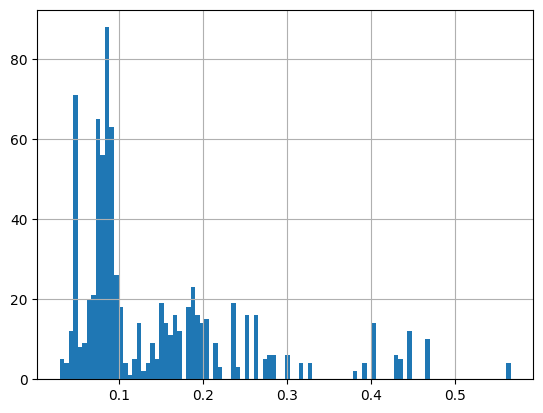

In [22]:
tfidf_df = pd.DataFrame({
    'tfidf_weight': tfidf_weights
})
tfidf_df.tfidf_weight.hist(bins=100)

#### PMI: word-word

In [23]:
# https://www.listendata.com/2022/06/pointwise-mutual-information-pmi.html

In [24]:
# flatten list of words into a single list of tokens.
tokens = [item for sublist in filtered_all_words for item in sublist]

# find bigrams with window size 10
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens, window_size=10)

edge_index = [[], []]
npmi_values = []

# calculate NPMI scores for each bigram.
for bigram, pmi_score in tqdm(finder.score_ngrams(bigram_measures.pmi)):
    if pmi_score > 0:
        word1, word2 = bigram

        # calculate normalization
        pxy = finder.ngram_fd[bigram] / finder.N 
        npmi = pmi_score / -np.log2(pxy)

        a = word_to_id[word1]
        b = word_to_id[word2]
        if a == b:
            continue
        edge_index[0].append(a)
        edge_index[1].append(b)
        npmi_values.append(npmi)

# convert to PyTOrch Tensor
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
npmi_values_tensor = torch.tensor(npmi_values, dtype=torch.float)



data['word', 'co_occurs_with', 'word'].edge_index = edge_index_tensor
data['word', 'co_occurs_with', 'word'].edge_attr = npmi_values_tensor

  0%|          | 0/6699 [00:00<?, ?it/s]

100%|██████████| 6699/6699 [00:00<00:00, 741714.86it/s]


<Axes: >

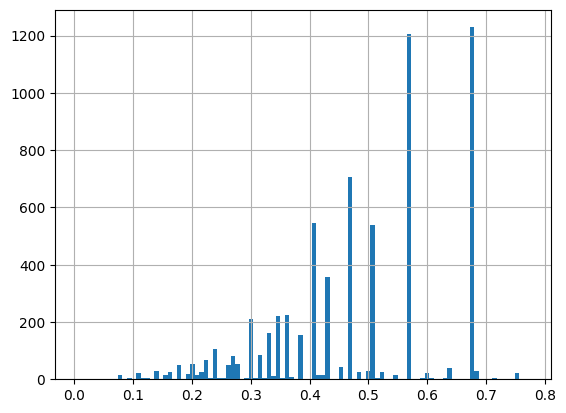

In [25]:
npmi = pd.DataFrame({"npmi":npmi_values_tensor})
npmi.npmi.hist(bins=100)

In [26]:
finder.score_ngrams(bigram_measures.pmi)

[(('-4.38', 'cycle'), 6.51306958223937),
 (('-4.38', 'number'), 6.51306958223937),
 (('-4.38', 'rad'), 6.51306958223937),
 (('-4.38', 's^(-2'), 6.51306958223937),
 (('-4.38', 'stirling'), 6.51306958223937),
 (('.001', '260'), 6.51306958223937),
 (('.001', 'assumed'), 6.51306958223937),
 (('.001', 'lsun'), 6.51306958223937),
 (('.001', 'pc'), 6.51306958223937),
 (('0', 'consequence'), 6.51306958223937),
 (('0', 'grid'), 6.51306958223937),
 (('0', 'hardy'), 6.51306958223937),
 (('0.85', '51'), 6.51306958223937),
 (('0.85', 'additional'), 6.51306958223937),
 (('0.85', 'cover'), 6.51306958223937),
 (('0.85', 'deg^2'), 6.51306958223937),
 (('1', '90'), 6.51306958223937),
 (('1', 'occupy'), 6.51306958223937),
 (('1', 'similar'), 6.51306958223937),
 (('2004', 'american'), 6.51306958223937),
 (('2004', 'behavior'), 6.51306958223937),
 (('2004', 'current'), 6.51306958223937),
 (('2004', 'physical'), 6.51306958223937),
 (('2004', 'society'), 6.51306958223937),
 (('235', '0.85'), 6.51306958223937

# Export

In [27]:
# Serialize and save the hetero-object
with open('hetero_graph.pkl', 'wb') as f:
    pickle.dump(data, f)